In [15]:
from PIL import Image
from PIL import ImageFilter
import skimage
from skimage import io, exposure, filters, morphology
from skimage.filters import unsharp_mask
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.ndimage import convolve
import sklearn
import math

Here there are 2 images: soccer1.bmp and soccer2.bmp which are two images taken one after the other. They have slight differences.

In [16]:
soccer1 = io.imread('./Images/soccer1.bmp')
soccer2 = io.imread('./Images/soccer2.bmp')

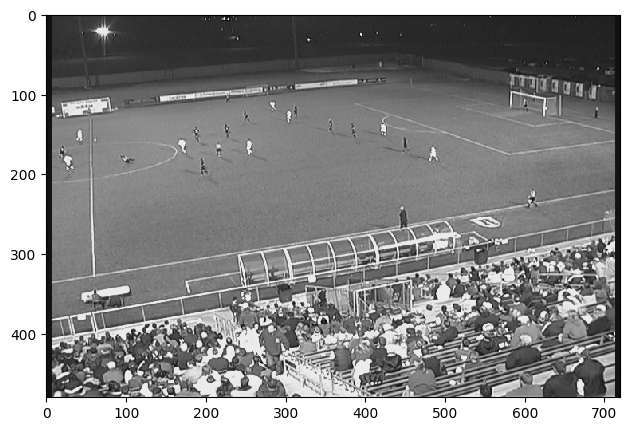

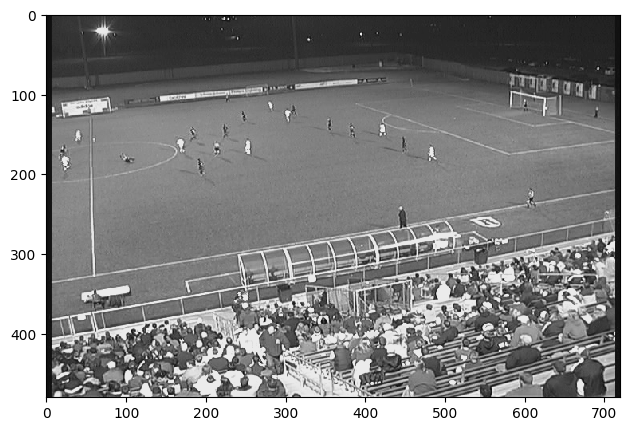

In [17]:
io.imshow(soccer1)
io.show()
io.imshow(soccer2)
io.show()

Below is the code for the absolute difference of the two images. For every pixel in soccer1 and soccer2, the absolute value of the difference is put into a new image.

In [18]:
absDiffSoccer = []
for i in range(min(len(soccer1), len(soccer2))):
    absDiffSoccer.append([])
    for j in range(min(len(soccer1[i]), len(soccer2[i]))):
        absDiffSoccer[i].append(min(soccer1[i][j] - soccer2[i][j], soccer2[i][j] - soccer1[i][j])) #This block of code is explained below
absDiffSoccer = np.array(absDiffSoccer)

C:\Users\jimxa\AppData\Local\Temp\ipykernel_10428\2030939257.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  absDiffSoccer[i].append(min(soccer1[i][j] - soccer2[i][j], soccer2[i][j] - soccer1[i][j])) #This block of code is explained below


The reason the minimum of the two differences is taken instead of the absolute value of one of the differences is because the numpy 2d array used here is of the type uint8. Meaning 16-17 would not result in -1 but rather an integer underflow to 255. 

In [19]:
absDiffSoccer

array([[1, 0, 1, ..., 2, 2, 1],
       [0, 1, 1, ..., 2, 2, 1],
       [0, 1, 1, ..., 2, 2, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

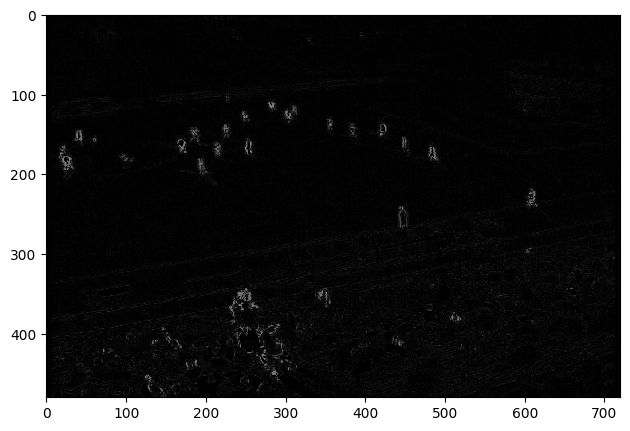

In [20]:
io.imshow(absDiffSoccer)
io.show()

Here is the histogram for the image above:

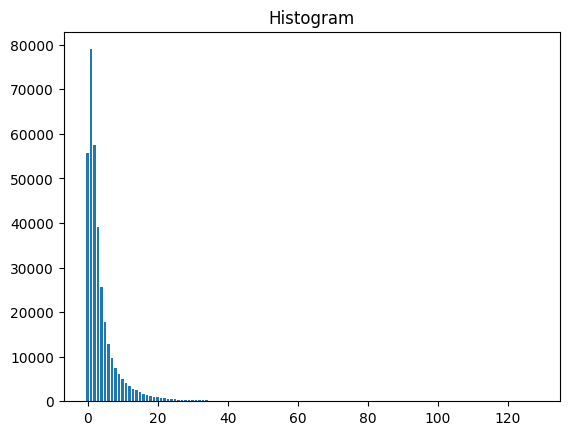

(array([55729, 78981, 57495, 39076, 25645, 17735, 12860,  9704,  7568,
         6116,  4936,  4188,  3328,  2850,  2435,  1986,  1659,  1423,
         1175,  1040,   863,   774,   647,   572,   474,   409,   381,
          313,   276,   253,   233,   221,   182,   180,   179,   146,
          118,   102,   105,    96,    87,    83,    75,    91,    73,
           86,    80,    60,    67,    69,    60,    63,    42,    57,
           33,    45,    45,    42,    38,    36,    45,    52,    53,
           45,    32,    32,    36,    36,    30,    40,    38,    31,
           31,    36,    43,    22,    22,    35,    36,    31,    24,
           29,    28,    32,    32,    27,    25,    28,    18,    27,
           24,    24,    22,    27,    22,    26,    21,    18,    24,
           15,    28,    22,    22,    29,    15,    28,    20,    22,
           29,    24,    30,    28,    19,    31,    30,    19,    25,
           22,    13,    27,    25,    22,    20,    32,    19,    33,
      

In [35]:
hist = exposure.histogram(absDiffSoccer)
plt.bar(hist[1], hist[0])
plt.title('Histogram')
plt.show()
hist

Below we are choosing a threshold p, to allow p% of pixels to be white and the rest to be black, to transform the image into a binary image (not to cut down in space).
We will be thresholding by a certain pixel value rather than taking exactly p% pixels, so p is more of an estimate of the percentage of pixels to be let through.

The code below for thresholding uses hist[0] (obtained from skimage.exposure.histogram) which is an array whose size is the number of bins in the histogram plot and each value in the array represents the number of pixels in that bin.

num is initially set to int(p * len(soccer1) * len(soccer1[0])). "len(soccer1) * len(soccer1[0])" are the dimensions of the image soccer1 and num is set to be p% of the total amount of pixels (int cast for simplicity).

We decrement from the end of hist[0] and keep track of which bin (pixel value) to keep as our threshold (stored in i).

In [84]:
p = 0.01
num = int(p * len(soccer1) * len(soccer1[0]))
i = len(hist[0]) - 1 
while(num > 0):
    num -= hist[0][i]
    i -= 1
treshold = i

Everything below the threshold pixel value is set to 0 and everything above is set to 255.

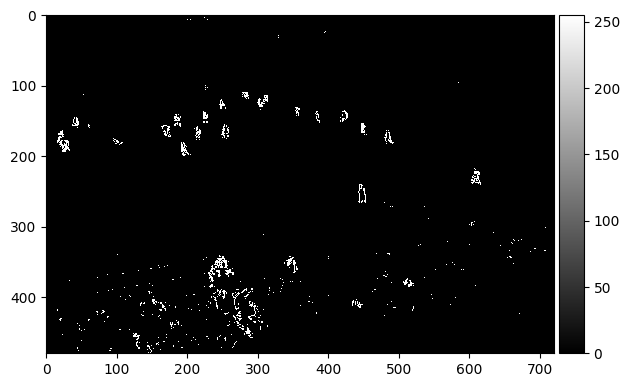

In [85]:
binarySoccer = []
for i in range(len(absDiffSoccer)):
    binarySoccer.append([])
    for j in absDiffSoccer[i]:
        if j >= treshold:
            binarySoccer[i].append(255)
        else:
            binarySoccer[i].append(0)
binarySoccer = np.array(binarySoccer)
io.imshow(binarySoccer, cmap=plt.cm.gray)
io.show()

Below we are using something called closing. Closing dilates the image first and then erodes the image. The point is to close up any holes in the image. Opening erodes the image first and then dilates the image to remove weak connections between 2 supposed objects to separate them.

Dilation is a morphological operation over the image that adds pixels arounds objecs over and over again to close holes and connect objects.

Erosion is the opposites, it removes pixels around objects to remove thin bridges and connections. 

When dilation is applied first, it strenghtens connections and closes holes so when erosion is applied the objects are still connected and holes are still closed.

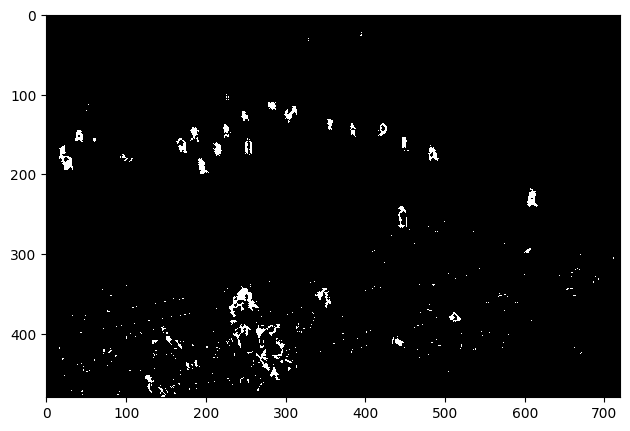

In [86]:
#Applying the skimage built in binary closing function on our recently thresholded "binary image"
binaryCloseSoccer = skimage.morphology.binary_closing(binarySoccer)
io.imshow(binaryCloseSoccer)
io.show()

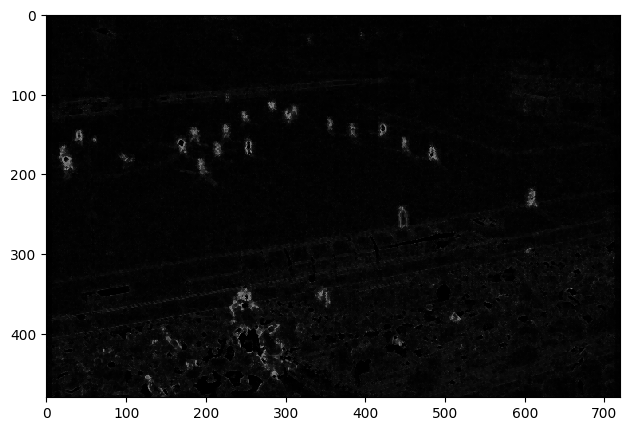

In [87]:
#Applying skimage built in closing function which works on grayscale images. Applied to the absolute difference image before thresholding
grayscaleCloseSoccer = skimage.morphology.closing(absDiffSoccer)
io.imshow(grayscaleCloseSoccer)
io.show()

After binary closing the new array contains booleans instead of 0s and 255s or 0s and 1s

In [88]:
binaryCloseSoccer

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Below, every pixel in the original 2 images that maps to true in binaryCloseSoccer is shown 

C:\Users\jimxa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


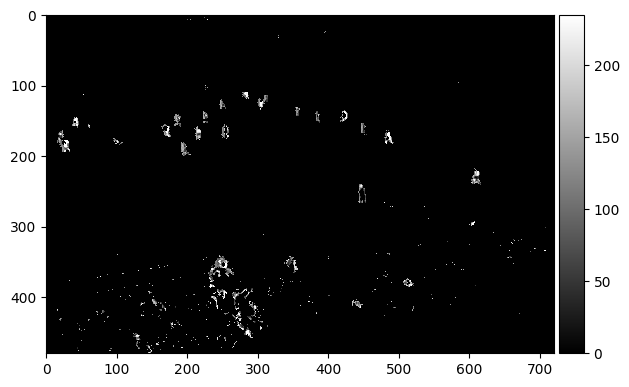

In [90]:
newSoccer1 = []
for i in range(len(binaryCloseSoccer)):
    newSoccer1.append([])
    for j in range(len(binaryCloseSoccer[i])):
        if binaryCloseSoccer[i][j]:
            newSoccer1[i].append(soccer1[i][j])
        else:
            newSoccer1[i].append(0)
newSoccer1 = np.array(newSoccer1)
io.imshow(newSoccer1, cmap=plt.cm.gray)
io.show()

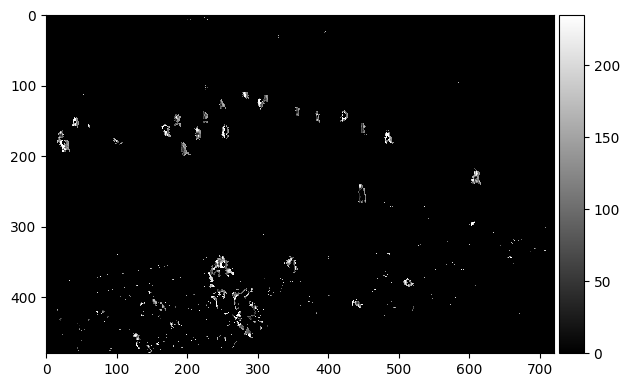

In [91]:
newSoccer2 = []
for i in range(len(binaryCloseSoccer)):
    newSoccer2.append([])
    for j in range(len(binaryCloseSoccer[i])):
        if binaryCloseSoccer[i][j]:
            newSoccer2[i].append(soccer2[i][j])
        else:
            newSoccer2[i].append(0)
newSoccer2 = np.array(newSoccer2)
io.imshow(newSoccer2, cmap=plt.cm.gray)
io.show()